## Forward backward asymmetry

In [5]:
# %load ../../style.py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import colorConverter
from matplotlib import rcParams
import seaborn as sns
from scipy.optimize import curve_fit
import itertools

sns.set(style='ticks', palette='Set2') 
sns.despine()

fontsize_labels = 26    # size used in latex document
rcParams['text.latex.preamble'] = [r'\usepackage[cmbright]{sfmath}']
rcParams['font.family']= 'sans-serif'
rcParams['font.sans-serif']= 'cmbright'
rcParams['font.weight'] = "light"

rcParams['text.usetex'] = True

rcParams['figure.autolayout'] = True
rcParams['font.size'] = fontsize_labels
rcParams['axes.labelsize'] = fontsize_labels
rcParams['xtick.labelsize'] = fontsize_labels
rcParams['ytick.labelsize'] = fontsize_labels
rcParams['legend.fontsize'] = fontsize_labels
rcParams['axes.titlesize'] = fontsize_labels
xfactor = 2
rcParams['figure.figsize'] = (xfactor*6.2, xfactor*3.83)  


In [99]:
import uncertainties as uc
import uncertainties.unumpy as un
import os
import pickle
from scipy.constants import alpha
import itertools
from IPython.display import Math

In [3]:
# Loading of the data. We saved the ROOT files before as .npy files
mm = np.load("data/mm.npy")
mm = mm[mm["cos_thet"] < 999] # use only 

/usr/lib/python3.4/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


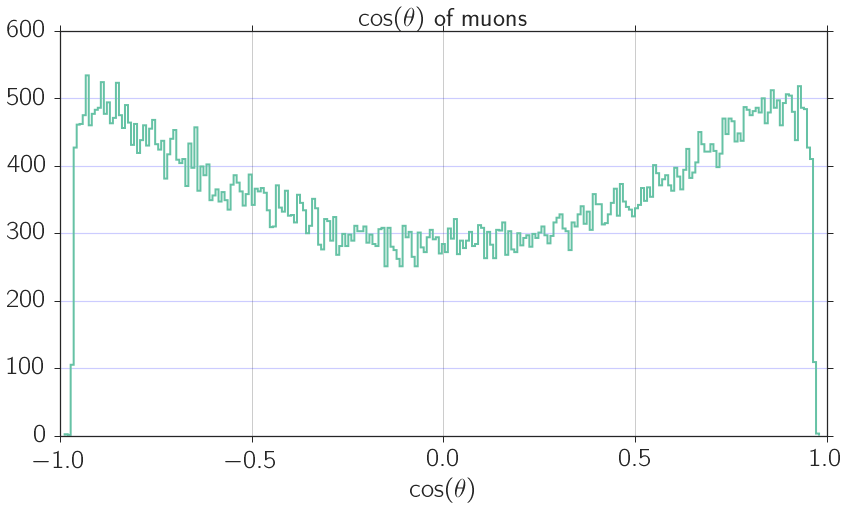

In [7]:
f, ax1 = plt.subplots(1, 1)

ax1.hist(mm["cos_thet"],250, histtype="step",linewidth=2)
ax1.set_title("$\\cos(\\theta)$ of muons")
ax1.set_xlabel("$\\cos(\\theta)$")
ax1.yaxis.grid(True,'minor',linewidth=0.5,color = "blue", alpha = 0.2)
ax1.yaxis.grid(True,'major',linewidth=1.2, color = "blue", alpha = 0.2)
ax1.xaxis.grid(True)
plt.show()

Calculate forward backward asymmetry:

In [5]:
N_b = np.sum(mm["cos_thet"] < 0)
N_f = np.sum(mm["cos_thet"] > 0)
A_fb= (N_f - N_b) / (N_f + N_b)
sin_t_w_sq = (1 - np.sqrt(A_fb / 3)) / 4

In [6]:
N_b, N_f, A_fb, sin_t_w_sq

(44709, 45114, 0.0045088674392972849, 0.24030800648376746)

## Real Data

In [78]:
all_data = np.load("data/data.npy")                                                                                                     
E_lep = np.unique(all_data["E_lep"])*2                                                                                                  
f = open("data/original/daten_4.lum")                                                                                                   
lumidata = f.read()                                                                                                                     
f.close()                                                                                                                               
mean_E = []                                                                                                                             
lumi   = {}  
for q in range(7):                                                                                                                      
    E = float(lumidata.split()[9+q*5])                                                                                                  
    mean_E += [E]                                                                                                                       
    lumi[E] = uc.ufloat(float(lumidata.split()[10+q*5]),float(lumidata.split()[13+q*5])) / (2.57*10**(-6))                                                                                                                                                        

all_data_sorted = {}                                                                                                                    
                                                                                                                                        
for E in mean_E:                                                                                                                        
    c_data = (all_data["E_lep"]*2 < (E + 0.5)) * (all_data["E_lep"]*2 > (E - 0.5))                                                      
    all_data_sorted[E]= all_data[c_data]  

E_now = 91.2243
u = all_data_sorted[E_now]

(82009,)

In [69]:
cut_type = "sup_knn"
all_ff = []                                                                                                                     
for ele in u:                                                                                                                   
    all_ff  += [[ele["Ncharged"],ele["Pcharged"],ele["E_ecal"],ele["E_hcal"]]]                                                  
all_ff  = np.array(all_ff)                                                                                                      
                                                                                                                                        
if os.path.isfile("./data/classifiers/%s.p"%(cut_type[4:])):                                                                    
    classifier = pickle.load( open("data/classifiers/%s.p"%(cut_type[4:]),"rb"))                                                
else:                                                                                                                           
    raise Exception("Classifier not trained!!!")                                                                                
                                                                                                                                        
pred = classifier.predict(all_ff)      
muons = u[pred == 2]
muons = muons[(muons["cos_thet"]!=999)]

/usr/lib/python3.4/site-packages/matplotlib/figure.py:1653: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


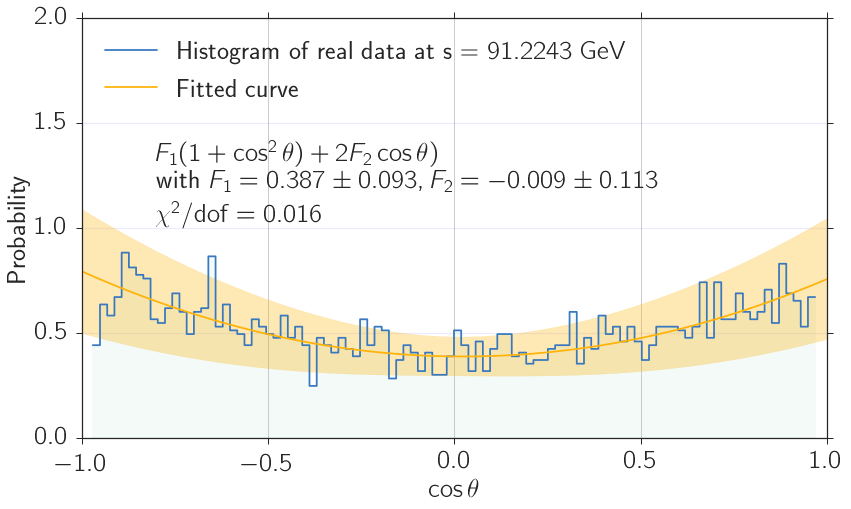

In [163]:
u = muons
def func(cos_theta,F1,F2):                                                                                                                                                                                                                                                    
    return (F1*(1+cos_theta**2) + 2 * F2 * cos_theta)
                                                                                                                                                                                                                                                                              
# inital guess                                                                                                                                                                                                                                                                    
F1 = 1                                                                                                                                                                                                                                                                             
F2 = 1                                                                                                                                                                                                                                                                             
                                                                                                                                                                                                                                                                                  
N_mm, cos_thet = np.histogram(u["cos_thet"],100, density=True)                                                                                                                                                                                                                    
#sigma = np.sqrt(N_ee), absolute_sigma = True                                                                                                                                                                                                                                     
p, cov = curve_fit(func, cos_thet[1:], N_mm, p0=[F1,F2],sigma = np.sqrt(N_mm+1), absolute_sigma = True)                                                                                                                                                                       

chi2 = np.sum(((func(cos_thet[0:-1],*p) - N_mm) / np.sqrt(N_mm)) ** 2 )/(len(N_mm)-len(p))

p_uc = uc.correlated_values(p,cov)                                                                                                                                                                                                                                                
F1,F2 = p_uc



edges = cos_thet
width = edges[3] - edges[2]
edges2 = []
P_all2 = []
for k in range(len(edges[1:])):
    edges2 += [edges[k]]
    edges2 += [edges[k]+width*0.9999]
    P_all2 += [N_mm[k]]
    P_all2 += [N_mm[k]]

colors = ["windows blue", "amber", "pale red", "faded green", "dusty purple"]   
palette = itertools.cycle(sns.xkcd_palette(colors) )
color = next(palette)

fig, ax = plt.subplots(1,1)
gridalpha = 0.08

ax.plot(edges2,P_all2,"-", label="Histogram of real data at s = $91.2243 \: \mathrm{GeV}$",color = color)
ax.fill_between(edges2,0,P_all2,alpha = 0.08)

ax.yaxis.grid(True,'minor',linewidth=0.5,color = "blue", alpha = gridalpha)
ax.yaxis.grid(True,'major',linewidth=1.2, color = "blue", alpha = gridalpha)
ax.xaxis.grid(True)

cos_theta = np.linspace(-1,1,1000)

# t s channel
data_fit = func(cos_theta,*p)
error_on_fit = un.std_devs(func(cos_theta,*p_uc) )  
data_fit_min = data_fit - error_on_fit
data_fit_max = data_fit + error_on_fit


color = next(palette)
ax.plot(cos_theta,data_fit, color = color,  label = "Fitted curve")
ax.fill_between(cos_theta, data_fit_min , data_fit_max, alpha=0.3,  color = color )

props = dict(boxstyle='round', facecolor='white', alpha=0.0)
textstr = "$F_1 ( 1 + \\cos^2\\theta) + 2 F_2 \\cos \\theta)$\
\n with $F_1=%.3f \pm %.3f, F_2 = %.3f \pm %.3f$ \n"%(F1.n,F1.s,F2.n,F2.s)
textstr += "$\chi^2/\mathrm{dof} = %.3f$"%chi2
ax.text(0.1, 0.7,textstr , transform=ax.transAxes, fontsize=26,
        verticalalignment='top', bbox=props)

ax.set_xlim(-1,1)
ax.set_ylim(0,2)
ax.legend(loc = 2)
ax.set_ylabel("Probability")
ax.set_xlabel("$\\cos\\theta$")
plt.savefig("../figures/assymetry.pdf")

plt.show()
     

In [98]:
A_FB = 3 * F2 / (4*F1)
sintheta2 = (1 - un.sqrt(np.abs(A_FB)/3))/4

In [154]:
Math("A_{FB} = %.5f \pm %.5f"%(A_FB.n, A_FB.s))

<IPython.core.display.Math object>

In [106]:
Math("\sin^2\\theta_W = %.5f \pm %.5f"%(sintheta2.n, sintheta2.s))

<IPython.core.display.Math object>

In [157]:
print("\sin^2\\theta_W = %.5f \pm %.5f"%(sintheta2.n, sintheta2.s))

\sin^2\theta_W = 0.23069 \pm 0.11769


In [158]:
print("A_{FB} = %.5f \pm %.5f"%(A_FB.n, A_FB.s))

A_{FB} = -0.01790 \pm 0.21817


In [14]:
colors = ["windows blue", "amber", "pale red", "faded green", "dusty purple"] 
palette = lambda: itertools.cycle(sns.xkcd_palette(colors) )

In [15]:
colorpick = palette()

In [19]:
next(colorpick)

(0.4823529411764706, 0.6980392156862745, 0.4549019607843137)